In [1]:
from Code_utilities.VideoUtilities.VideoToNumpy import VideoToNumpy
from Code_utilities.DataPlotter import DataPlotter
from Code_utilities.VideoUtilities.AmplitudeSpectralDensityCalculator import AmplitudeSpectralDensityCalculator
from Code_utilities.DataFitter import DataFitter
from Code_utilities.SeriesAnalyzer_2 import SeriesAnalyzer_2
from Code_utilities.BeamAnalysis import BeamAnalysis
import matplotlib.pyplot as plt
plt.close('all')


class NEPCalculator:
    def __init__(self,):
        ''''Relevant parameters for analysis'''
        self.video_path = ('/Users/Shared/Files From c.localized/Gabriel_UniBern_Local/DataAnalysis/Low cost THz '
              'Camera/20250508/Noise_Analysis/video_25fps_closed_camera_300frames.csv')
        #self.power_series_path = '/Users/Shared/Files From c.localized/Gabriel_UniBern_Local/DataAnalysis/Low cost THz Camera/20250603/HIKMICRO_PowerSeries'
        self.power_series_path= '/Users/Shared/Files From c.localized/Gabriel_UniBern_Local/DataAnalysis/Low cost THz Camera/20250616/HIKMICRO/Power Series'
        self.camera_name = 'HIKMICRO'
        self.pixel_block_size_for_asd_average = 100

        self.angle_pol_voltage_measurement_HIKMICRO=90
        self.measured_voltage_converted_from_lock_in_to_osciloscope_V_HIKMICRO = .555
        self.moved_pol =  'first'
        # x_center_HIKMICRO = 152 - 1
        # y_center_HIKMICRO = 122
        x_center_HIKMICRO = 138
        y_center_HIKMICRO = 107
        width = 50

        self.crop_x_range_HIKMICRO = (x_center_HIKMICRO - width / 2, x_center_HIKMICRO + width / 2)
        self.crop_y_range_HIKMICRO = (y_center_HIKMICRO - width / 2, y_center_HIKMICRO + width / 2)

        if self.camera_name == 'HIKMICRO':
            self.frame_rate = 25

        #self.asd_at_1hz=self.get_asd_at_1hz()


    def plot_asd(self):
        frames_array = VideoToNumpy(video_path=self.video_path,
                                    camera_name=self.camera_name).frames

        AmplitudeSpectraDensity = AmplitudeSpectralDensityCalculator(
            frames_array,
            frame_rate_Hz=self.frame_rate,
            pixel_block_size=self.pixel_block_size_for_asd_average)

        freqs, mean_asd = AmplitudeSpectraDensity.freqs, AmplitudeSpectraDensity.mean_asd

        Plot = DataPlotter()

        fig, ax, asd_1hz = Plot.plot_asd_figure(freqs=freqs,
                                                mean_asd=mean_asd,
                                                bool_print_asd_at_1hz=False,)

        return fig, ax, asd_1hz

    def get_asd_at_1hz(self):
        _, _, asd_1hz = self.plot_asd()
        return asd_1hz

    def plot_map_example(self,
                         filename):
        crop_x_range_HIKMICRO=self.crop_x_range_HIKMICRO
        crop_y_range_HIKMICRO=self.crop_y_range_HIKMICRO
        HIKMICRO_dir_path=self.power_series_path

        beam_analysis_HIKMICRO = BeamAnalysis(dir_path=HIKMICRO_dir_path,
                                              signal_filename=filename,
                                              camera_name=self.camera_name,
                                              crop_range_x_pixels=crop_x_range_HIKMICRO,
                                              crop_range_y_pixels=crop_y_range_HIKMICRO)
        fig_HIKMICRO, ax_HIKMICRO = beam_analysis_HIKMICRO.plot_map_in_pixels()
        return fig_HIKMICRO, ax_HIKMICRO

    def get_responsivity(self):

        crop_x_range_HIKMICRO=self.crop_x_range_HIKMICRO
        crop_y_range_HIKMICRO=self.crop_y_range_HIKMICRO
        angle_pol_voltage_measurement_HIKMICRO = self.angle_pol_voltage_measurement_HIKMICRO
        measured_voltage_converted_from_lock_in_to_osciloscope_V_HIKMICRO = self.measured_voltage_converted_from_lock_in_to_osciloscope_V_HIKMICRO
        moved_pol = self.moved_pol
        HIKMICRO_dir_path=self.power_series_path

        HIKMICRO_SeriesAnalyzer = SeriesAnalyzer_2(dir_path=HIKMICRO_dir_path,
                                           camera_name=self.camera_name,
                                           Y_ref_position_for_background_subtraction=3,
                                           crop_range_x_pixels=crop_x_range_HIKMICRO,
                                           crop_range_y_pixels=crop_y_range_HIKMICRO)

        beam_characterization_df_HIKMICRO = HIKMICRO_SeriesAnalyzer.get_beam_char_df_w_powers(save_data_plot_bool=True,
                                                                            known_angle=angle_pol_voltage_measurement_HIKMICRO,
                                                                            known_voltage_at_known_angle_in_V= measured_voltage_converted_from_lock_in_to_osciloscope_V_HIKMICRO,
                                                                            moved_polarizer=moved_pol,)

        fig_fitting_NEC, ax_fitting_NEC = DataFitter().plot_data_with_fit_for_paper(
            x_data=beam_characterization_df_HIKMICRO['Power (uW)'],
            y_data=beam_characterization_df_HIKMICRO['total_intensity'],
            x_label=r'Power (uW)',
            y_label='Intensity (a.u.)',
            title=self.camera_name,
            camera_name=self.camera_name,
        )
        fitting_coefficients_HIKMICRO_all_together=DataFitter().get_fitting_coefficients(x_data=beam_characterization_df_HIKMICRO['Power (uW)'],
                                                                            y_data=beam_characterization_df_HIKMICRO['total_intensity'],)
        responsivity_degrees_uW=fitting_coefficients_HIKMICRO_all_together[0]

        return responsivity_degrees_uW

    def calculate_NEP(self):
        self.responsivity_degrees_uW=self.get_responsivity()
        self.asd_1hz=self.get_asd_at_1hz()

        NEP_uW_srqHz=self.asd_1hz/self.responsivity_degrees_uW

        uW_to_pW=10**6
        NEP_pW_srqHz=NEP_uW_srqHz*uW_to_pW

        return NEP_pW_srqHz




In [2]:
%matplotlib widget
NEPCalculator = NEPCalculator()

Loading full video file into memory ...
Loaded 300 frames (192×256).
Calculating ASD for 10000 pixels in a 100x100 block...


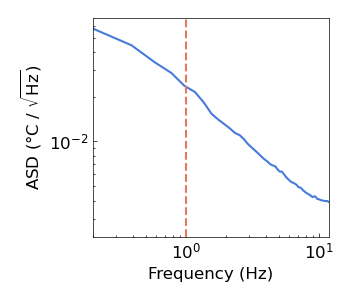

In [3]:
fig_asd, ax_asd, asd_1hz = NEPCalculator.plot_asd()
ax_asd.set_xlim(0.2, 12)
fig_asd.tight_layout()
fig_asd.savefig('/Users/Shared/Files From c.localized/Gabriel_UniBern_Local/Manuscripts/Low THz Camera MS/Figures/SI/ASD/'+NEPCalculator.camera_name+'_ASD.pdf')

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Map'}, xlabel='x (pixels)', ylabel='y (pixels)'>)

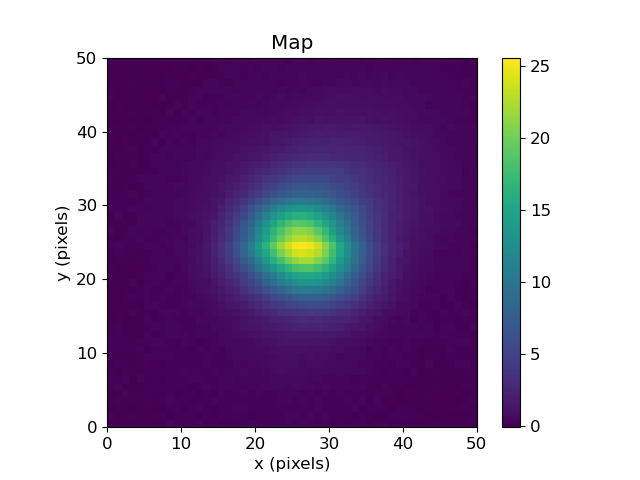

In [4]:

NEPCalculator.plot_map_example(filename='50 degrees.csv')

Moved first polarizer


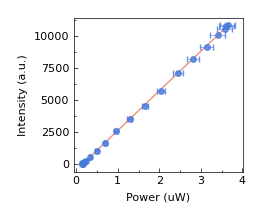

Moved first polarizer


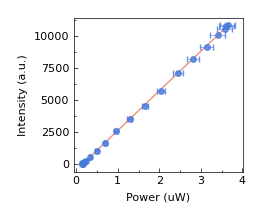

Loading full video file into memory ...
Loaded 300 frames (192×256).
Calculating ASD for 10000 pixels in a 100x100 block...


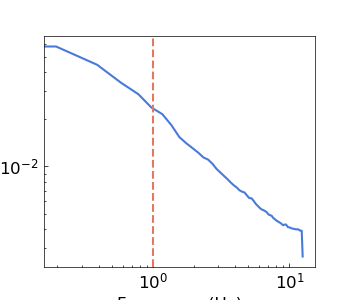

In [5]:
responsivity=NEPCalculator.get_responsivity()
NEP_pW_srqHz=NEPCalculator.calculate_NEP()
